In [1]:
import numpy as np
import matplotlib.pyplot as plt

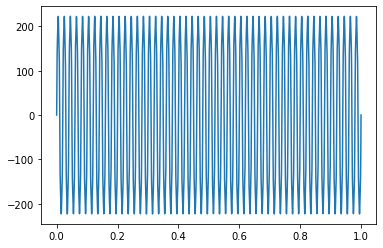

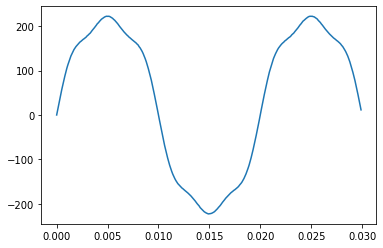

In [6]:
# --------------------------------------------------------
# Signal simulation
# --------------------------------------------------------

def simulateSignal(f0, A0, fmod, Amod, tlen, fs):
    ''' 
    Simulates a signal with the following paramters
    
    f0: fundamental frequency
    A0: amplitude of fundamental frequency 
    fmod: frequency of amplitude modulation
    Amod: amplitude of modulating signal
    tlen: time duration of signal (measurement)
    fs: sampling rate of adc
    
    Returns: array of simulated discrete signal
    
    Note: Signal has third and fifth harmonics of amplitude 1/10 and 1/15 of the fundamental frequency amplitude respectively.
    Change function as desired.
    '''
    
    t = np.linspace(0,tlen,int(fs*tlen)) # generate time axis for signal
    
    xmod = (A0 + Amod*np.sin(2*np.pi*fmod*t)) # generate modulating waveform
    x = np.sin(2*np.pi*f0*t) + (1/10)*np.sin(2*np.pi*3*f0*t) + (1/15)*np.sin(2*np.pi*5*f0*t) # create signal with harmonics
    x = (x*xmod) # modulate signal
    x = x + np.random.normal(0,0.2,int(fs*tlen)) # add noise
    
    return x



### Testing function
tlen = 1 # length of signal
fs = 10000

t = np.linspace(0,tlen,int(fs*tlen)) # generating time axis for signal
x = simulateSignal(50, 230, 10, 0.05, tlen, fs)

plt.figure(); plt.plot(t,x)
plt.figure(); plt.plot(t[:300], x[:300]) # zoom in

In [7]:
# --------------------------------------------------------
# Autocorrelation to obtain fundamental frequency
# --------------------------------------------------------

def qaudratic_interpolate(a, b, c, b_pos):
    '''
    Performs quadratic interpolation for a set of three adjacent values to obtain location (x-coordinate) of peak
    
    a, b, c: three adjacent samples to which parabola is to be fitted
    b_pos: index of middle sample
    
    Returns: non-discrete 'index' of peak
    '''
    
    return b_pos+(0.5*(a-c)/(a-(2*b)+c))


def compute_f0_acf(x, fs):
    '''
    Determines fundamental frequency of a signal using autocorrelation
    
    Parameters:
    x: signal whose fundamental frequency is to be determined
    fs: sampling frequency of signal x
    
    The ACF of the signal is not actually fully computed or stored to save on space and time.
    Instead, a state machine is used to detect the second peak in the ACF (first peak is always at 0 maximum). 
    
    The states are:
    STATE 0 : set threshold under which value we'll ignore the data. NEW STATE = 1
    STATE 1 : check if signal is above threshold AND slope of the signal is positive. If so, move to STATE 2.
    STATE 2 : check if slope of signal has become negative or zero. If so, peak has been found. Move to STATE 3.
    STATE 3 : exit state machine.
    
    Returns: fundamental frequency (f0)
    '''
    
    thresh = 0
    f0 = 0
    STATE = 0
    sum = 0
    prev_sum = 0
    L = 0 # fundamental frequency period expressed in samples
    
    L_det = 0
    count = 0
    
    R = np.zeros(len(x))
    
    # Autocorrelation with peak detection
    for m in range(len(x)):
        prev_prev_sum = prev_sum
        prev_sum = sum
        sum = 0
        
        for n in range(len(x)-m):
            sum += x[n] * x[n+m] # not storing ACF in order to store memory
                    
        # State machine to obtain three adjacent points around peak for quadratic interpolation
        if (STATE == 2 and (sum - prev_sum) <0): # if gradient change, obtain current and previous two values
            L = qaudratic_interpolate(prev_prev_sum, prev_sum, sum, m-1)
            STATE = 3
            break
            
        if (STATE == 1 and (sum > thresh) and (sum - prev_sum) > 0):
            STATE = 2
            
        if (m == 0):
            thresh = sum * 0.5 # peaks to be detected are above half the first peak (maximum value of ACF)
            STATE = 1
            
    
    # Computing frequency in Hz
    f0 = fs/L;
    
    if (f0 < 40 and f0 > 60):
        print('Fundamental frequency too far from 50 Hz!')
    
    return f0



### Testing
fs = 10000
x = simulateSignal(50, 230, 10, 0.05, 2, fs)  # simulate signal with 3rd and 5th harmonics
# x = x[700:] # adding phase shift to signal

f0 = compute_f0_acf(x, fs)
print(f0)

50.00248577557491


complex value at  50.00248577557491  Hz =  (239.29254942411015-2299894.780264885j)
magnitude at  50.00248577557491  Hz =  2299894.7927134815
phase at  50.00248577557491  Hz =  -1.5706922817965714

complex value at (FFT) 50.00248577557491  Hz =  (36156.373147656865-2299584.8617880475j)
magnitude at (FFT) 50.00248577557491  Hz =  2299869.087553452
phase at (FFT) 50.00248577557491  Hz =  -1.5550746220856468


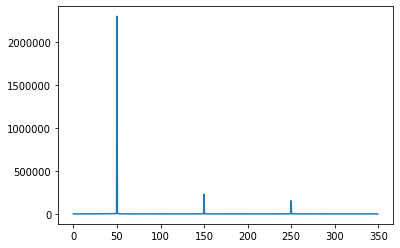

In [10]:
# -----------------------------------------------------------
# Magnitude and phase computation for specific frequencies
# -----------------------------------------------------------

def spectral_value(x, f, fs):
    '''
    Uses Discrete Time Fourier Transform formula to obtain the complex value of the signal's spectrum at a particular
    frequency.
    
    Parameters:
    x: time domain signal whose frequency component is to be computed
    f: frequency (Hz) of interest
    fs: sample rate
    
    Returns: complex value of frequency component
    '''
    R = 0 # real part
    I = 0 # complex part
    frel = f/fs # relative frequency. Equation of DTFT actually uses cycles/sample not cycles/sec (i.e. Hz).
    
    for n in range(len(x)):
        R += x[n] * np.cos(2*np.pi*frel*n)
        I += x[n] * np.sin(2*np.pi*frel*n)
    
    return np.complex(R, (-1*I)) # !!! careful not to forget the negative 


### Testing
X_f0 = spectral_value(x, f0, fs)
print("complex value at ", f0, " Hz = ", X_f0)
print("magnitude at ", f0, " Hz = ", np.abs(X_f0))
print("phase at ", f0, " Hz = ", np.angle(X_f0))

# Verifying with FFT
X = np.fft.fft(x)
freq = np.fft.fftfreq(len(x), 1/fs)
plt.plot(freq[:700], abs(X)[:700])

Xmag = abs(X)
f0_index = np.argmax(Xmag)
print("\ncomplex value at (FFT)", f0, " Hz = ", X[f0_index])
print("magnitude at (FFT)", f0, " Hz = ", np.abs(X[f0_index]))
print("phase at (FFT)", f0, " Hz = ", np.angle(X[f0_index]))

In [ ]:
# --------------------------------------------------------
# Dataset Simulation for GPT
# --------------------------------------------------------

f0 = 50                                             # fundametal frequency [Hz]
fs = 9765.625                                       # sampling frequency of ADC
tlen = 5                                            # duration of measurement interval
trunc = 10000                                       # truncation of plot

v1 = simulateSignal(f0, 230, 10, 0.05, tlen, fs)    # line 1 voltage
v2 = simulateSignal(f0, 235, 10, 0.05, tlen, fs)    # line 2 voltage
v3 = simulateSignal(f0, 50, 10, 0.05, tlen, fs)     # line 3 voltage
v4 = simulateSignal(f0, 20, 10, 0.05, tlen, fs)     # line 4 voltage

i1 = simulateSignal(f0, 2, 10, 0.05, tlen, fs)      # line 1 current
i2 = simulateSignal(f0, 0.5, 10, 0.05, tlen, fs)    # line 2 current
i3 = simulateSignal(f0, 0.88, 10, 0.05, tlen, fs)   # line 3 current
i4 = simulateSignal(f0, 0.6, 10, 0.05, tlen, fs)    # line 4 current

r1 = 500                                            # line 1 resistance
r2 = 1000                                           # line 2 resistance
r3 = 5000                                           # line 3 resistance
r4 = 2000                                           # line 4 resistance